# Advanced Latent Optimization Strategies

This notebook demonstrates the improved `optimize_latent` method with:
1. Random initialization (no need for initial_input)
2. Perturbation mechanism to avoid local optima
3. Multi-restart strategy for global search
4. Comparison of different initialization strategies

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from foundation_model.models.flexible_multi_task_model import FlexibleMultiTaskModel
from foundation_model.models.model_config import (
    MLPEncoderConfig,
    RegressionTaskConfig,
    AutoEncoderTaskConfig,
    OptimizerConfig,
)

torch.manual_seed(42)
np.random.seed(42)

print("✓ Libraries loaded")

✓ Libraries loaded


## Assume we have a trained model

For this demo, we'll create a simple model. In practice, you'd load a pre-trained model.

In [2]:
# Create a simple trained model
input_dim = 190
latent_dim = 128

encoder_config = MLPEncoderConfig(
    hidden_dims=[input_dim, 256, latent_dim],
    norm=True
)

density_task = RegressionTaskConfig(
    name="density",
    data_column="density",
    dims=[latent_dim, 64, 1],
    norm=True,
)

ae_task = AutoEncoderTaskConfig(
    name="reconstruction",
    data_column="__autoencoder__",
    dims=[latent_dim, 256, input_dim],
    norm=True,
)

model = FlexibleMultiTaskModel(
    shared_block_dims=[input_dim, 256, latent_dim],
    encoder_config=encoder_config,
    task_configs=[density_task, ae_task],
    shared_block_optimizer=OptimizerConfig(lr=0.05),
)

model.eval()
print("✓ Model created")
print(f"  Input dim: {input_dim}")
print(f"  Latent dim: {latent_dim}")

2025-11-23 04:00:35.926 | INFO     | flexible_multi_task_model:__init__:164 - Learnable task uncertainty (task_log_sigmas) is DISABLED.
2025-11-23 04:00:35.936 | INFO     | flexible_multi_task_model:__init__:178 - Initializing FlexibleMultiTaskModel...
2025-11-23 04:00:35.937 | INFO     | flexible_multi_task_model:__init__:179 - Registered Task Heads:
2025-11-23 04:00:35.940 | INFO     | flexible_multi_task_model:__init__:186 -             name        type  enabled
2025-11-23 04:00:35.941 | INFO     | flexible_multi_task_model:__init__:186 -          density  REGRESSION     True
2025-11-23 04:00:35.941 | INFO     | flexible_multi_task_model:__init__:186 -   reconstruction AUTOENCODER     True
2025-11-23 04:00:35.942 | INFO     | flexible_multi_task_model:__init__:190 - FlexibleMultiTaskModel Structure:
2025-11-23 04:00:35.942 | INFO     | flexible_multi_task_model:__init__:194 -   FlexibleMultiTaskModel(
2025-11-23 04:00:35.942 | INFO     | flexible_multi_task_model:__init__:194 -     

✓ Model created
  Input dim: 190
  Latent dim: 128


## Strategy 1: Random Initialization (No initial_input needed!)

The improved method doesn't require an initial input - it can start from a random latent vector.

Random Initialization Results:
  Initial score: -0.0364
  Optimized score: 128.1526
  Improvement: 128.1889


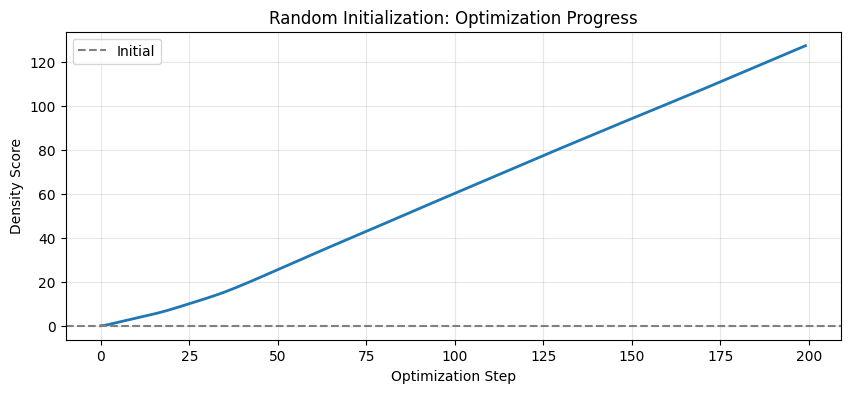

In [3]:
# Optimize from a random starting point
result_random = model.optimize_latent(
    task_name="density",
    initial_input=None,  # No initial input required!
    mode="max",
    steps=200,
    lr=0.05,
    ae_task_name="reconstruction"
)

print("Random Initialization Results:")
print(f"  Initial score: {result_random['initial_score']:.4f}")
print(f"  Optimized score: {result_random['optimized_score'].item():.4f}")
print(f"  Improvement: {result_random['optimized_score'].item() - result_random['initial_score']:.4f}")

# Plot optimization trajectory
plt.figure(figsize=(10, 4))
plt.plot(result_random['history'], linewidth=2)
plt.axhline(result_random['initial_score'], color='gray', linestyle='--', label='Initial')
plt.xlabel('Optimization Step')
plt.ylabel('Density Score')
plt.title('Random Initialization: Optimization Progress')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Strategy 2: Perturbation Around a Known Point

If you have a known good sample, add perturbation to explore the neighborhood.

Baseline sample score: -0.0708

Perturbation 0.00: Score = 243.4034, Improvement = +243.4742
Perturbation 0.05: Score = 243.5233, Improvement = +243.5862
Perturbation 0.10: Score = 243.1213, Improvement = +243.1764
Perturbation 0.20: Score = 249.4371, Improvement = +249.5205
Perturbation 0.50: Score = 237.3246, Improvement = +237.3457


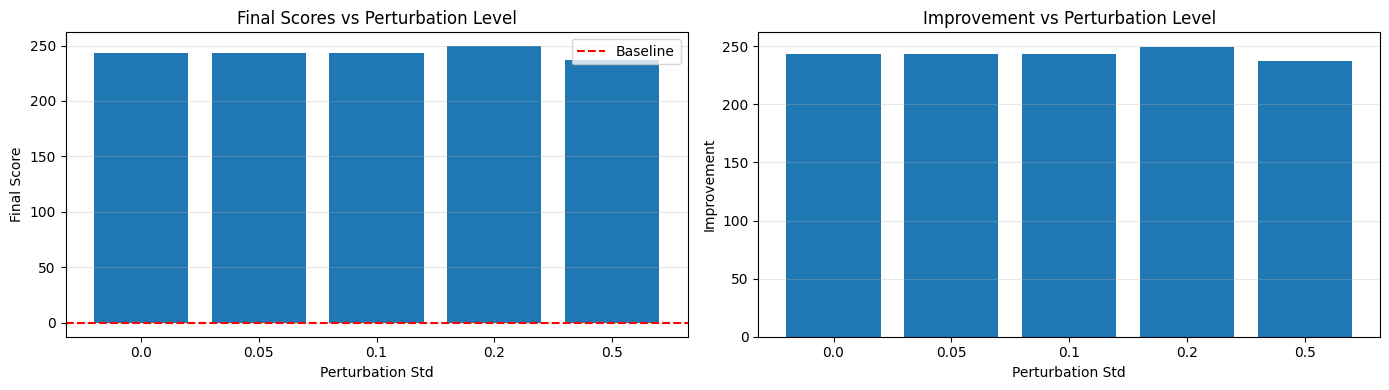

In [4]:
# Create a "known good sample" (in practice, this would be from your dataset)
good_sample = torch.randn(1, input_dim)

# Get baseline score
with torch.no_grad():
    _, h = model.encoder(good_sample)
    baseline_score = model.task_heads["density"](h).item()

print(f"Baseline sample score: {baseline_score:.4f}\n")

# Try different perturbation levels
perturbation_levels = [0.0, 0.05, 0.1, 0.2, 0.5]
results_perturbation = []

for perturb_std in perturbation_levels:
    result = model.optimize_latent(
        task_name="density",
        initial_input=good_sample,
        mode="max",
        steps=200,
        perturbation_std=perturb_std,
        ae_task_name="reconstruction"
    )
    results_perturbation.append({
        'perturbation': perturb_std,
        'final_score': result['optimized_score'].item(),
        'improvement': result['optimized_score'].item() - result['initial_score']
    })
    print(f"Perturbation {perturb_std:.2f}: Score = {result['optimized_score'].item():.4f}, "
          f"Improvement = {result['optimized_score'].item() - result['initial_score']:+.4f}")

# Plot comparison
df_perturb = pd.DataFrame(results_perturbation)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].bar(df_perturb['perturbation'].astype(str), df_perturb['final_score'])
axes[0].axhline(baseline_score, color='red', linestyle='--', label='Baseline')
axes[0].set_xlabel('Perturbation Std')
axes[0].set_ylabel('Final Score')
axes[0].set_title('Final Scores vs Perturbation Level')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

axes[1].bar(df_perturb['perturbation'].astype(str), df_perturb['improvement'])
axes[1].axhline(0, color='gray', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Perturbation Std')
axes[1].set_ylabel('Improvement')
axes[1].set_title('Improvement vs Perturbation Level')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Strategy 3: Multi-Restart for Global Search

Try multiple random starts and pick the best result to avoid local optima.

Running optimization with 20 random restarts...



2025-11-23 04:00:56.213 | INFO     | flexible_multi_task_model:optimize_latent:1719 - Completed 20 restarts. Best score: 137.4921 (restart 3)


Best result:
  Score: 137.4921
  From restart: 3

Statistics across 20 restarts:
  Score range: 114.2564 - 137.4921
  Mean score: 126.7996 ± 6.6331
  Best improvement: 134.8954


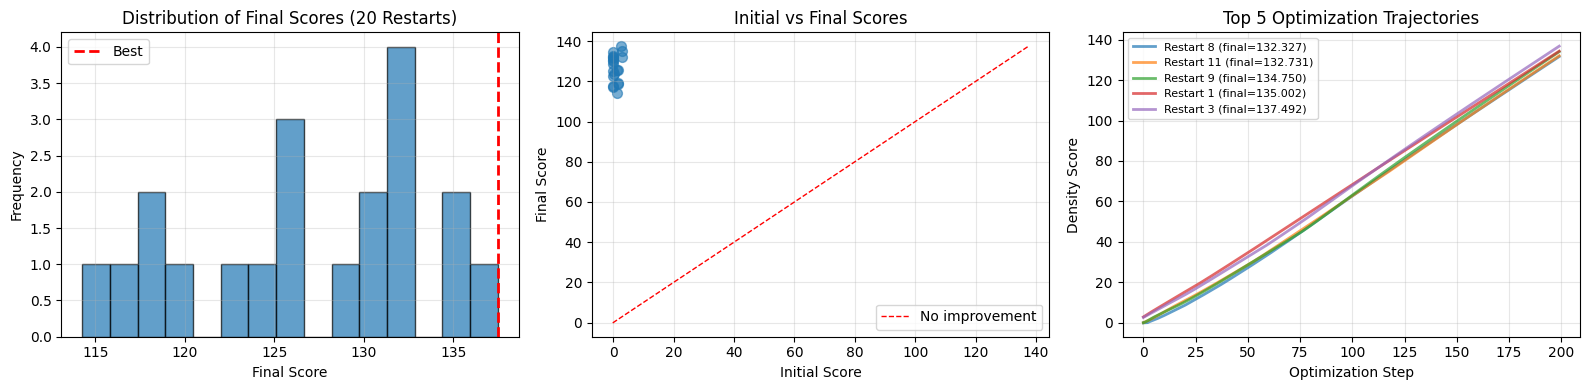

In [5]:
# Global search with multiple restarts
print("Running optimization with 20 random restarts...\n")

result_multistart = model.optimize_latent(
    task_name="density",
    initial_input=None,  # Random initialization for each restart
    mode="max",
    steps=200,
    lr=0.05,
    num_restarts=20,  # Try 20 different starting points
    ae_task_name="reconstruction"
)

print(f"Best result:")
print(f"  Score: {result_multistart['optimized_score'].item():.4f}")
print(f"  From restart: {[r['restart_idx'] for r in result_multistart['all_restarts'] if r['optimized_score'].item() == result_multistart['optimized_score'].item()][0]}")

# Analyze all restarts
all_scores = [r['optimized_score'].item() for r in result_multistart['all_restarts']]
all_initial = [r['initial_score'] for r in result_multistart['all_restarts']]
all_improvements = [final - init for final, init in zip(all_scores, all_initial)]

print(f"\nStatistics across {len(all_scores)} restarts:")
print(f"  Score range: {min(all_scores):.4f} - {max(all_scores):.4f}")
print(f"  Mean score: {np.mean(all_scores):.4f} ± {np.std(all_scores):.4f}")
print(f"  Best improvement: {max(all_improvements):.4f}")

# Visualize all restart results
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Distribution of final scores
axes[0].hist(all_scores, bins=15, alpha=0.7, edgecolor='black')
axes[0].axvline(result_multistart['optimized_score'].item(), 
               color='red', linestyle='--', linewidth=2, label='Best')
axes[0].set_xlabel('Final Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Final Scores (20 Restarts)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Initial vs Final scores
axes[1].scatter(all_initial, all_scores, alpha=0.6, s=50)
lims = [min(min(all_initial), min(all_scores)), max(max(all_initial), max(all_scores))]
axes[1].plot(lims, lims, 'r--', linewidth=1, label='No improvement')
axes[1].set_xlabel('Initial Score')
axes[1].set_ylabel('Final Score')
axes[1].set_title('Initial vs Final Scores')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Optimization trajectories for top 5 restarts
top_5_indices = np.argsort(all_scores)[-5:]
for idx in top_5_indices:
    history = result_multistart['all_restarts'][idx]['history']
    label = f"Restart {idx} (final={all_scores[idx]:.3f})"
    axes[2].plot(history, alpha=0.7, linewidth=2, label=label)
axes[2].set_xlabel('Optimization Step')
axes[2].set_ylabel('Density Score')
axes[2].set_title('Top 5 Optimization Trajectories')
axes[2].legend(fontsize=8)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Strategy 4: Hybrid - Known Point + Multi-Restart + Perturbation

Combine all strategies: start from a good point, add perturbation, and use multiple restarts.

Hybrid optimization: Good starting point + perturbation + multiple restarts



2025-11-23 04:01:05.515 | INFO     | flexible_multi_task_model:optimize_latent:1719 - Completed 10 restarts. Best score: 124.5868 (restart 8)


Hybrid optimization results:
  Best score: 124.5868
  Baseline: -0.0708
  Improvement over baseline: +124.6576


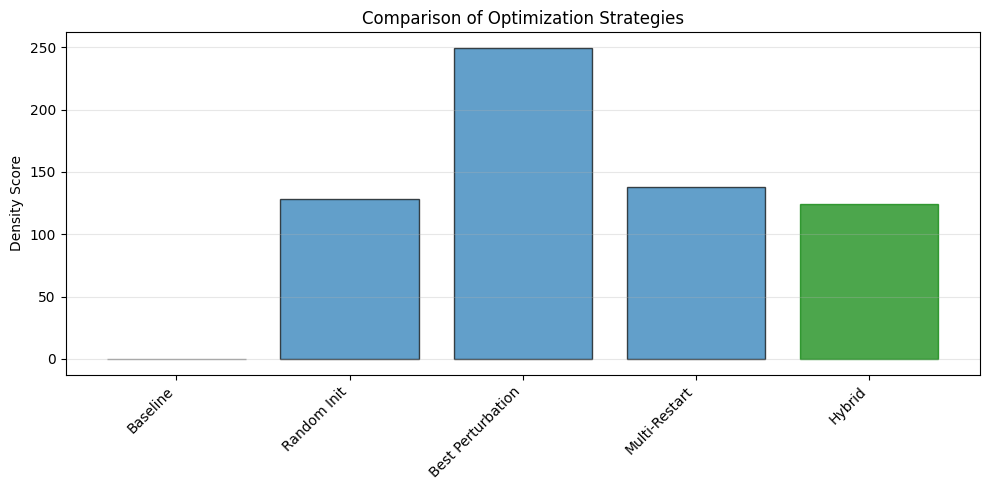


STRATEGY COMPARISON
Baseline            : -0.0708 (+0.0000)
Random Init         : 128.1526 (+128.2234)
Best Perturbation   : 249.4371 (+249.5078)
Multi-Restart       : 137.4921 (+137.5629)
Hybrid              : 124.5868 (+124.6576)


In [6]:
# Hybrid approach
print("Hybrid optimization: Good starting point + perturbation + multiple restarts\n")

result_hybrid = model.optimize_latent(
    task_name="density",
    initial_input=good_sample,  # Start from known good sample
    mode="max",
    steps=200,
    lr=0.05,
    num_restarts=10,  # Multiple restarts
    perturbation_std=0.2,  # Add moderate perturbation
    ae_task_name="reconstruction"
)

print(f"Hybrid optimization results:")
print(f"  Best score: {result_hybrid['optimized_score'].item():.4f}")
print(f"  Baseline: {baseline_score:.4f}")
print(f"  Improvement over baseline: {result_hybrid['optimized_score'].item() - baseline_score:+.4f}")

# Compare with previous strategies
strategies = {
    'Baseline': baseline_score,
    'Random Init': result_random['optimized_score'].item(),
    'Best Perturbation': max(r['final_score'] for r in results_perturbation),
    'Multi-Restart': result_multistart['optimized_score'].item(),
    'Hybrid': result_hybrid['optimized_score'].item(),
}

plt.figure(figsize=(10, 5))
bars = plt.bar(strategies.keys(), strategies.values(), alpha=0.7, edgecolor='black')
bars[0].set_color('gray')  # Baseline
bars[-1].set_color('green')  # Hybrid (best)
plt.ylabel('Density Score')
plt.title('Comparison of Optimization Strategies')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("STRATEGY COMPARISON")
print("="*60)
for name, score in strategies.items():
    improvement = score - baseline_score
    print(f"{name:20s}: {score:.4f} ({improvement:+.4f})")
print("="*60)

## Analyzing the Reconstructed Descriptors

Let's compare the descriptors from different optimization strategies.

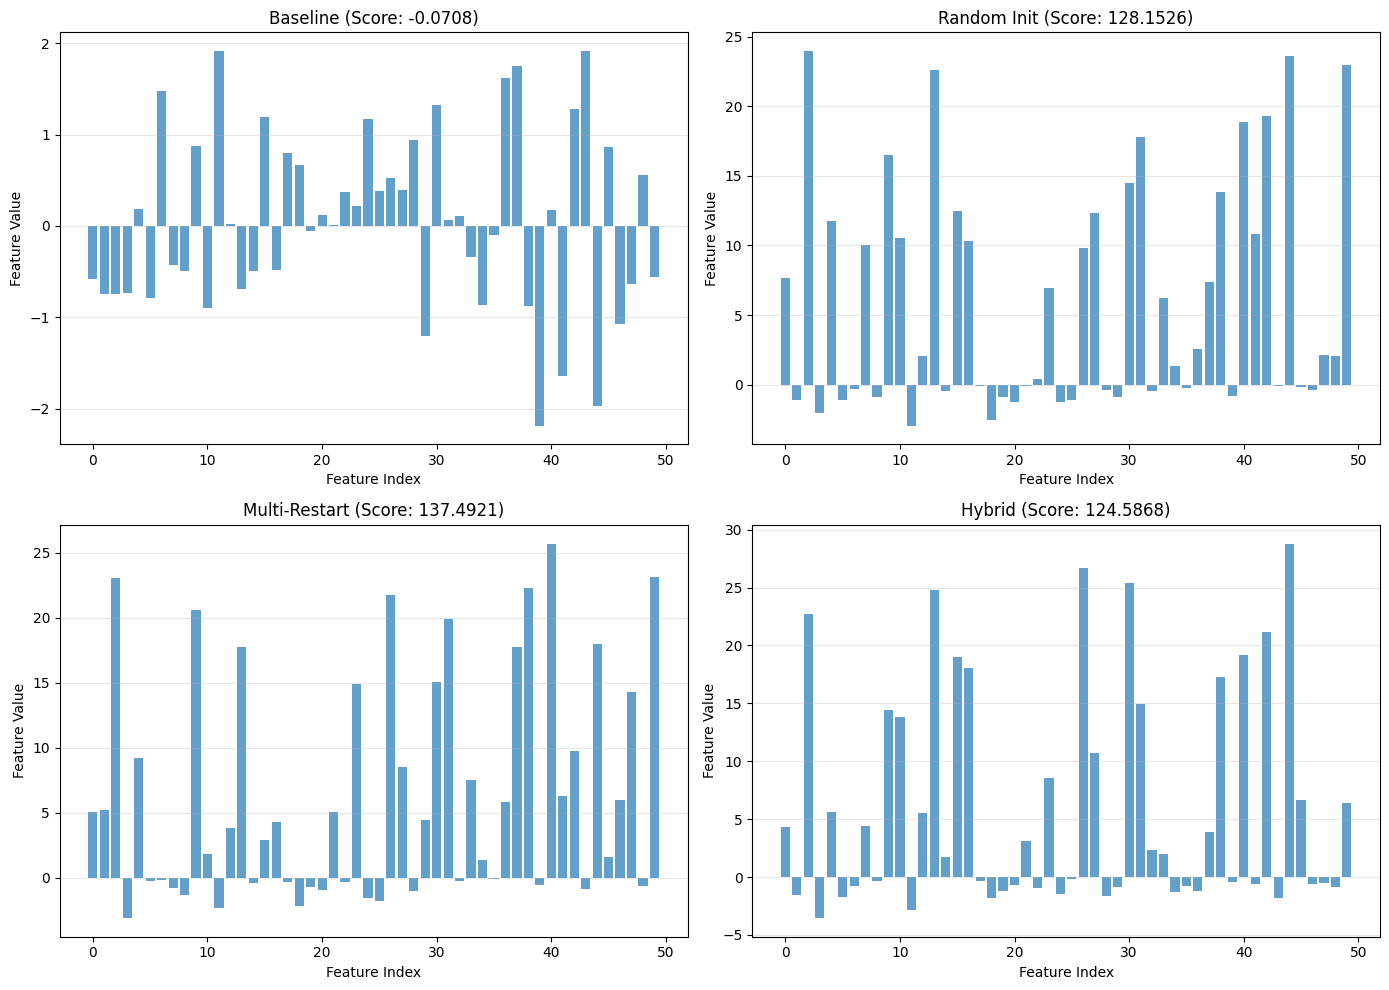

Descriptor statistics (first 50 features):

Baseline:
  Mean: 0.0466
  Std: 0.9690
  Range: [-2.1834, 1.9136]

Random Init:
  Mean: 6.0299
  Std: 8.1255
  Range: [-2.9294, 23.9657]

Multi-Restart:
  Mean: 6.4610
  Std: 8.5352
  Range: [-3.1119, 25.7250]

Hybrid:
  Mean: 6.0710
  Std: 9.3308
  Range: [-3.5403, 28.8025]


In [7]:
# Get reconstructed descriptors
descriptors = {
    'Baseline': good_sample.cpu().numpy().flatten(),
    'Random Init': result_random['reconstructed_input'].cpu().numpy().flatten(),
    'Multi-Restart': result_multistart['reconstructed_input'].cpu().numpy().flatten(),
    'Hybrid': result_hybrid['reconstructed_input'].cpu().numpy().flatten(),
}

# Visualize first 50 features
n_show = 50
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, desc) in enumerate(descriptors.items()):
    axes[idx].bar(range(n_show), desc[:n_show], alpha=0.7)
    axes[idx].set_xlabel('Feature Index')
    axes[idx].set_ylabel('Feature Value')
    axes[idx].set_title(f'{name} (Score: {strategies[name]:.4f})')
    axes[idx].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistical comparison
print("Descriptor statistics (first 50 features):")
for name, desc in descriptors.items():
    print(f"\n{name}:")
    print(f"  Mean: {np.mean(desc[:n_show]):.4f}")
    print(f"  Std: {np.std(desc[:n_show]):.4f}")
    print(f"  Range: [{np.min(desc[:n_show]):.4f}, {np.max(desc[:n_show]):.4f}]")

## Recommendations

Based on these experiments:

### 1. **For Quick Exploration**
```python
result = model.optimize_latent(
    task_name="property",
    initial_input=None,
    mode="max",
    num_restarts=5
)
```

### 2. **For Improving Known Materials**
```python
result = model.optimize_latent(
    task_name="property",
    initial_input=existing_material,
    perturbation_std=0.1,
    num_restarts=5
)
```

### 3. **For Production (Best Results)**
```python
result = model.optimize_latent(
    task_name="property",
    initial_input=best_known_material,  # or None
    mode="max",
    steps=500,
    num_restarts=50,
    perturbation_std=0.2,
)
```

### Key Insights:

- ✅ **No initial_input required** - method works with random initialization
- ✅ **Perturbation helps** - adds diversity and avoids always finding the same local optimum
- ✅ **Multi-restart is powerful** - significantly increases chance of finding global optimum
- ✅ **Hybrid strategy** - combining all techniques often gives best results
- ✅ **Computational cost** - scales linearly with `num_restarts`, so choose based on your time budget